<a href="https://colab.research.google.com/github/tophercollins/red_card_goal_analysis/blob/main/red_card_goal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setup

# European Football Red Card Exploratory Data Analysis

## Introduction
This study investigates the relationship between red cards and goals in football matches, specifically addressing whether red cards lead to more goals overall (i.e. more goals were scored by either team). The analysis uses data from two datasets, games.csv and events.csv, covering five seasons of games from 10 European national leagues across five countries.


## Data
We will be using the following datasets:
* **games.csv:** Contains fixtures from 10 European national leagues over five seasons.
* **events.csv:** Contains event data of red cards and goals, with minute timings corresponding to the matches in games.csv

## Structure

0. Setup: Prepare data and enviroment for analysis.
1. Exploratory Data Analysis (EDA):

  This section provides an initial exploration of the datasets, and is split into two parts:

  * Undestanding The Data
  * Correlation Analysis: Identifying signs of correlation between red cards and number of goals

2. Modelling:

  We tackle the following questions using hypothesis testing to statistically assess the relationship between red cards and goals, primarily using a Poisson distribution as a basis for comparison.

  1. Do red cards lead to more goals?

  We compare the mean number of goals scored in games with red card events against games without red card events.

  2. Do earlier red cards increase the likelihood of more goals?

  We analyse the timing of red card events to see if earlier red cards influence the number of goals, including a Linear Regression model comparing number of goals to red card minute.


3. Furthers Analysis:

To gain additional insights, we address the following, albeit with less rigorous testing.

  3. Does the rate of goal-scoring increase after a red card?
  
  We compare the goal-scoring rate in minutes where red cards have not occurred and minutes where red cards have occurred.

  4. Are more goals scored right after a red card event?
  
  We examine trends to see if goals are more likely to be scored immediately after a red card.

4. Conclusions:
A final look at our study.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import data
games_df_original = pd.read_csv('https://raw.githubusercontent.com/tophercollins/red_card_goal_analysis/refs/heads/main/games.csv', index_col=0, parse_dates=['date'])
events_df_original = pd.read_csv('https://raw.githubusercontent.com/tophercollins/red_card_goal_analysis/refs/heads/main/events.csv')

games_df = games_df_original.copy()
events_df = events_df_original.copy()

## 1. Exploratory Data Analysis (EDA)

### Understanding The Data

#### games.csv

We have 19,294 games across 5 years/seasons, with the following features:

* **game_id** - unique game identifier
* **home_team**
* **away_team**
* **competitions:** league and country
* **date** - YYYY-MM-DD format
* **home_goals**
* **away_goals**

In [ ]:
games_df.head()

,home_team,away_team,competition,date,home_goals,away_goals
game_id,,,,,,
1,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2
2,Red Star,Niort,"Ligue 2, France",2018-07-27,1,2
3,Ajaccio,Troyes,"Ligue 2, France",2018-07-27,0,1
4,Gazélec Ajaccio,Paris,"Ligue 2, France",2018-07-27,1,1
5,Clermont,Châteauroux,"Ligue 2, France",2018-07-27,0,0


In [ ]:
games_df.describe()

,date,home_goals,away_goals
count,19294,19294.000000,19294.000000
mean,2021-01-12 12:21:56.554369280,1.443920,1.166010
min,2018-07-27 00:00:00,0.000000,0.000000
25%,2019-10-20 00:00:00,1.000000,0.000000
50%,2021-01-30 00:00:00,1.000000,1.000000
75%,2022-03-19 00:00:00,2.000000,2.000000
max,2023-06-04 00:00:00,9.000000,9.000000
std,NaN,1.230304,1.117779


Dated between 2018-07-27 and 2023-06-04

In [ ]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19294 entries, 1 to 19294
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   home_team    19294 non-null  object        
 1   away_team    19294 non-null  object        
 2   competition  19294 non-null  object        
 3   date         19294 non-null  datetime64[ns]
 4   home_goals   19294 non-null  int64         
 5   away_goals   19294 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.0+ MB


There is no missing data.

#### Overall games info

We'll create a number of goals feature as we are not focusing home or away goals or specifically which side may be impacted.

In [ ]:
# Add number of goals feature to games_df
games_df['number_of_goals'] = games_df['home_goals'] + games_df['away_goals']

# Calculate summaries

def calculate_summary(df, column):
    summary = []
    summary.append(df[column].count())
    summary.append(df[column].sum())
    summary.append(df[column].mean())
    summary.append(df[column].std())
    return summary

# Calculate summary for number of goals
number_of_games, number_of_goals, mean_goals_per_game, goal_variance = calculate_summary(games_df, 'number_of_goals')
print(f'Number of games: {number_of_games}')
print(f'Number of goals: {number_of_goals}')
print(f'Mean goals per game: {mean_goals_per_game}')
print(f'Goal variance: {goal_variance}')

Number of games: 19294
Number of goals: 50356
Mean goals per game: 2.6099305483570023
Goal variance: 1.6287079041199053


#### Key Numbers:

**Number of games:** 19,294

**Number of goals:** 50,356

**Mean goals per game:** 2.61

**Goal variance:** 1.63

#### League games info

Let's explore our data across different groups to see what range of data we are working with.

In [ ]:
goals_info = {'Overall': calculate_summary(games_df, 'number_of_goals')}
for league in games_df['competition'].unique():
  league_data = games_df[games_df['competition'] == league]
  goals_info[league] = calculate_summary(league_data, 'number_of_goals')

goals_df = pd.DataFrame(goals_info, index=['number_of_goals', 'number_of_games', 'mean_goals_per_game', 'goal_variance'])
# Reorder the columns
goals_df = goals_df.reindex(['Overall', 'Ligue 1, France', 'Ligue 2, France',
       '1. Bundesliga, Germany', '2. Bundesliga, Germany', 'Premier League, England',
       'Championship, England', 'Primera, Spain',
       'Segunda, Spain', 'Serie A, Italy', 'Serie B, Italy'], axis=1)
goals_df = goals_df.T
# Change dtypes to integers
goals_df['number_of_games'] = goals_df['number_of_games'].astype(int)
goals_df['number_of_goals'] = goals_df['number_of_goals'].astype(int)
# Change mean_goals_per_game float to .2f precision
goals_df['mean_goals_per_game'] = goals_df['mean_goals_per_game'].apply(lambda x: f'{x:.2f}')
goals_df['goal_variance'] = goals_df['goal_variance'].apply(lambda x: f'{x:.2f}')
# Show goals info
goals_df.style.background_gradient(cmap='Blues', subset=['mean_goals_per_game'])

,number_of_goals,number_of_games,mean_goals_per_game,goal_variance
Overall,19294,50356,2.61,1.63
"Ligue 1, France",1802,4860,2.70,1.63
"Ligue 2, France",1800,4149,2.31,1.57
"1. Bundesliga, Germany",1530,4808,3.14,1.72
"2. Bundesliga, Germany",1530,4486,2.93,1.70
"Premier League, England",1900,5285,2.78,1.66
"Championship, England",2761,6932,2.51,1.57
"Primera, Spain",1900,4784,2.52,1.60
"Segunda, Spain",2309,5065,2.19,1.46
"Serie A, Italy",1900,5399,2.84,1.67


* Across the 10 leagues, the highest mean goals per game we see is 3.14 (1. Bundesliga, Germany), the lowest is 2.19 (Segunda, Spain). This shows a spread of 0.95 mean goals per game.

#### Yearly games info

In [ ]:
# Split years on 06-20
year_split = '-06-20'
year_info = {}
for year in games_df['date'].dt.year.unique()[:-1]:
  year_start = pd.to_datetime(str(year) + year_split)
  year_end = pd.to_datetime(str(year + 1) + year_split)
  year_data = games_df[(games_df['date'] > year_start) & (games_df['date'] < year_end)]
  # Calculate summary for number of goals
  year_info[year] = calculate_summary(year_data, 'number_of_goals')

year_df = pd.DataFrame(year_info, index=['number_of_goals', 'number_of_games', 'mean_goals_per_game', 'goal_variance'])
# Reorder the columns
year_df = year_df.T
year_df['mean_goals_per_game'] = year_df['mean_goals_per_game'].apply(lambda x: f'{x:.2f}')
year_df['goal_variance'] = year_df['goal_variance'].apply(lambda x: f'{x:.2f}')
# Change dtypes to integers
year_df['number_of_games'] = year_df['number_of_games'].astype(int)
year_df['number_of_goals'] = year_df['number_of_goals'].astype(int)
year_df.style.background_gradient(cmap='Blues', subset=['mean_goals_per_game'])

,number_of_goals,number_of_games,mean_goals_per_game,goal_variance
2018,3867,10122,2.62,1.65
2019,3066,8031,2.62,1.61
2020,4505,11728,2.60,1.62
2021,3908,10342,2.65,1.62
2022,3907,10034,2.57,1.65


The yearly averages have a much smaller spread of mean goals per game.

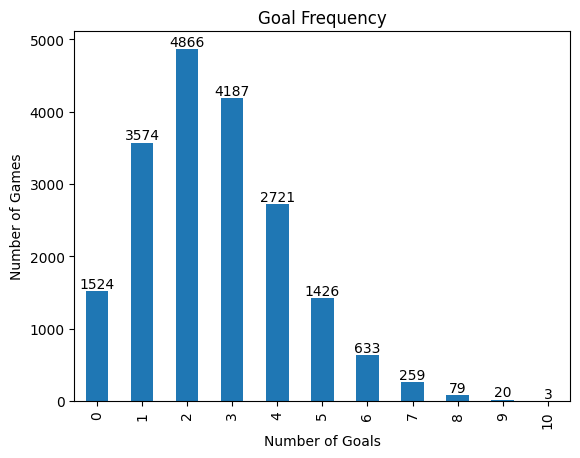

In [ ]:
# Goal frequency info
goal_frequency = games_df['number_of_goals'].value_counts().reindex(range(0, 11), fill_value=0)
# Plot as a vertical bar chart
goal_frequency.plot(kind='bar', title='Goal Frequency')
plt.xlabel('Number of Goals')
plt.ylabel('Number of Games')
# Add numbers to each bar
for i, v in enumerate(goal_frequency):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

Above we see the distribution of the number of goals, which matches a Poisson distribution extremely well as we will see later.
It is worth noting that the Poisson distribution assumes a constant rate of an event (in our case goals).

Yet we can see from our league data above, that there is a large variation in the number of goals per game across the different leagues.

So it’s important to remember that while Poisson is a good starting point, there is clearly influence from other external factors.


#### events.csv

We have just under 54,451 events across 5 years, with the following features:

* **game_id** - matching game_id identifier from games.csv
* **minute** - numerical - *0 to 90* - **does not include minutes for added time**
* **side** - 2 classes - *home, away*
* **type** - 2 classes - *red_card, goal*

In [ ]:
events_df

,game_id,minute,side,type
0,1,69,home,red_card
1,4,90,home,red_card
2,14,85,away,red_card
3,26,90,away,red_card
4,29,71,away,red_card
...,...,...,...,...
54446,19292,85,home,goal
54447,19293,43,home,goal
54448,19293,90,home,goal
54449,19293,6,away,goal


For events that occur at the same minute, we do not know the order.

So for red cards or goals that occur at the same minute, we must skip these values when we are considering the impact of a red card on those goals.

In [ ]:
events_df.head()

,game_id,minute,side,type
0,1,69,home,red_card
1,4,90,home,red_card
2,14,85,away,red_card
3,26,90,away,red_card
4,29,71,away,red_card


In [ ]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54451 entries, 0 to 54450
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   game_id  54451 non-null  int64 
 1   minute   54451 non-null  int64 
 2   side     54451 non-null  object
 3   type     54451 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


There is no missing data.

In [ ]:
# Add number_of_red_cards to games_df
number_of_red_cards = events_df[events_df['type'] == 'red_card'].groupby('game_id').size().reset_index(name='number_of_red_cards')
games_df = pd.merge(games_df, number_of_red_cards, on='game_id', how='left')
games_df = games_df.fillna(0)
games_df['number_of_red_cards'] = games_df['number_of_red_cards'].astype(int)
games_df['red_card_occured'] = games_df['number_of_red_cards'].apply(lambda x: 1 if x > 0 else 0)
first_red_card_events = events_df[events_df['type'] == 'red_card'].groupby('game_id')['minute'].min().reset_index(name='first_red_card_minute')
games_df = pd.merge(games_df, first_red_card_events, on='game_id', how='left')
games_df.head()

,game_id,home_team,away_team,competition,date,home_goals,away_goals,number_of_goals,number_of_red_cards,red_card_occured,first_red_card_minute
0,1,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2,2,1,1,69.0
1,2,Red Star,Niort,"Ligue 2, France",2018-07-27,1,2,3,0,0,NaN
2,3,Ajaccio,Troyes,"Ligue 2, France",2018-07-27,0,1,1,0,0,NaN
3,4,Gazélec Ajaccio,Paris,"Ligue 2, France",2018-07-27,1,1,2,1,1,90.0
4,5,Clermont,Châteauroux,"Ligue 2, France",2018-07-27,0,0,0,0,0,NaN


#### Overall info

In [ ]:
number_of_games_with_red_cards = games_df['red_card_occured'].sum()
number_of_red_cards = games_df['number_of_red_cards'].sum()
mean_red_cards_per_game = games_df['number_of_red_cards'].mean()
print(f'Number of games: {number_of_games}')
print(f'Number of games with red cards: {number_of_games_with_red_cards}')
print(f'Number of red cards: {number_of_red_cards}')
print(f'Mean red cards per game: {mean_red_cards_per_game}')

Number of games: 19294
Number of games with red cards: 3575
Number of red cards: 4131
Mean red cards per game: 0.2141080128537369


#### Key Numbers:

**Number of events:** 54,451

**Number of games with red cards:** 3,575

**Number of red cards:** 4,131

**Mean red cards per game:** 0.21

#### Average Red Cards per Game

In [ ]:
red_cards_info = {'Overall': [number_of_games, number_of_red_cards, mean_red_cards_per_game]}
for league in games_df['competition'].unique():
  league_data = games_df[games_df['competition'] == league]
  league_red_cards = league_data['number_of_red_cards'].sum()
  league_games =  len(league_data)
  league_mean_red_cards_per_game = league_data['number_of_red_cards'].mean()
  red_cards_info[league] = [league_games, league_red_cards, league_mean_red_cards_per_game]

red_cards_df = pd.DataFrame(red_cards_info, index=['number_of_games', 'number_of_red_cards', 'mean_red_cards_per_game'])
# Reorder the columns
red_cards_df = red_cards_df.reindex(['Overall', 'Ligue 1, France', 'Ligue 2, France',
       '1. Bundesliga, Germany', '2. Bundesliga, Germany', 'Premier League, England',
       'Championship, England', 'Primera, Spain',
       'Segunda, Spain', 'Serie A, Italy', 'Serie B, Italy'], axis=1)
red_cards_df = red_cards_df.T
# Change dtypes to integers
red_cards_df['number_of_games'] = red_cards_df['number_of_games'].astype(int)
red_cards_df['number_of_red_cards'] = red_cards_df['number_of_red_cards'].astype(int)
# Change mean_goals_per_game float to .2f precision
red_cards_df['mean_red_cards_per_game'] = red_cards_df['mean_red_cards_per_game'].apply(lambda x: f'{x:.2f}')
# Show red_cards info
red_cards_df.style.background_gradient(cmap='Blues', subset=['mean_red_cards_per_game'])

,number_of_games,number_of_red_cards,mean_red_cards_per_game
Overall,19294,4131,0.21
"Ligue 1, France",1802,488,0.27
"Ligue 2, France",1800,481,0.27
"1. Bundesliga, Germany",1530,199,0.13
"2. Bundesliga, Germany",1530,286,0.19
"Premier League, England",1900,217,0.11
"Championship, England",2761,346,0.13
"Primera, Spain",1900,483,0.25
"Segunda, Spain",2309,654,0.28
"Serie A, Italy",1900,440,0.23


We see a substantial difference in the max and min number of red cards per game:
* 0.29 in Serie B, Italy and 0.11 in the Premier League, England
* This difference of 0.18 is nearly as large as our overall average of 0.21
* Such a difference reminds us that they are many factors that can instigate game time stats, which could also have an impact of goal scoring tendencies.

#### Games with Red Cards

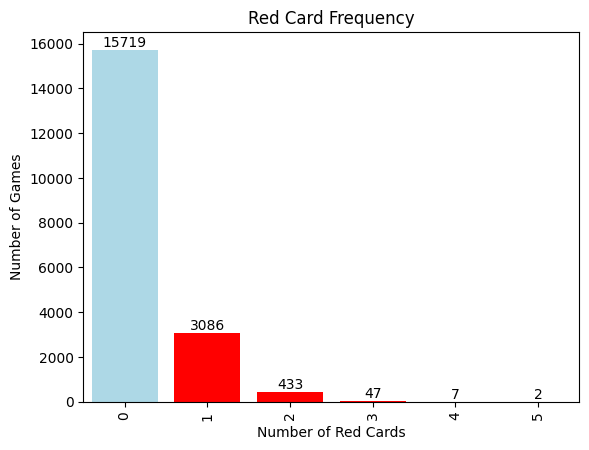

In [ ]:
# Red card games info
red_card_frequency = games_df['number_of_red_cards'].value_counts()
# Plot as a vertical bar chart
red_card_frequency.plot(kind='bar', title='Red Card Frequency')
plt.xlabel('Number of Red Cards')
plt.ylabel('Number of Games')
# Add numbers to each bar
for i, v in enumerate(red_card_frequency):
    plt.text(i, v, str(v), ha='center', va='bottom')
colors = ['lightblue'] + ['red'] * (len(red_card_frequency) - 1)
plt.bar(red_card_frequency.index, red_card_frequency.values, color=colors)
plt.show()

#### Events Distribution

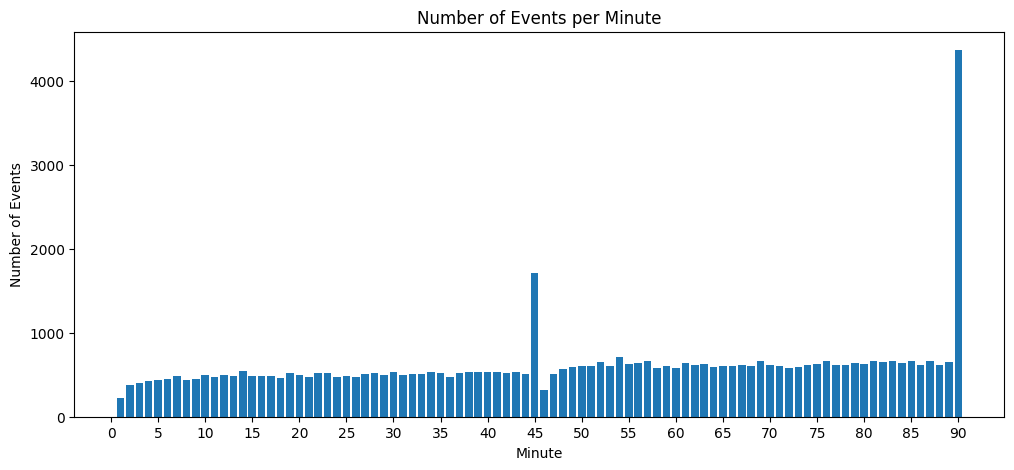

In [ ]:
# Bar plot for each minute
plt.figure(figsize=(12,5))
plt.bar(events_df['minute'].value_counts().index, events_df['minute'].value_counts().values)
plt.xticks(np.arange(0, 91, 5))
plt.xlabel('Minute')
plt.ylabel('Number of Events')
plt.title('Number of Events per Minute')
plt.show()

We can see significant outliers for the number of events taking place at minutes 45 and 90. This shows that our data contains events for ‘added time’ but does not include the exact minutes. This could create inaccuracies if we wish to calculate the 'per minute' values.

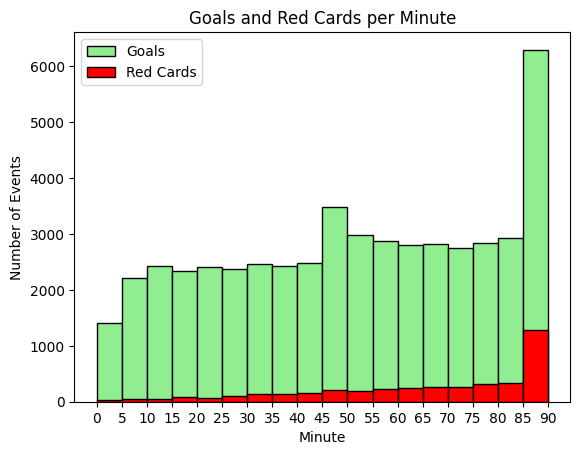

In [ ]:
# Histogram with 5 minute bins
goals_events = events_df[events_df['type'] == 'goal']
plt.hist(goals_events['minute'], bins=range(0, 91, 5), color='lightgreen', edgecolor='black')
red_cards_events = events_df[events_df['type'] == 'red_card']
plt.hist(red_cards_events['minute'], bins=range(0, 91, 5), color='red', edgecolor='black')
plt.xticks(np.arange(0, 91, 5))
plt.xlabel('Minute')
plt.ylabel('Number of Events')
plt.title('Goals and Red Cards per Minute')
plt.legend(['Goals', 'Red Cards'])
plt.show()

Here we see the event frequencies for both goals and red cards across 5 minute windows:

* More goals occur in the second half overall.

* Red cards however, do seem to show a linear increase.

* This makes sense as red cards can be the result of two yellow cards, which are more likely to accumulate over time.


In [ ]:
# Top event minutes
events_per_minute = events_df['minute'].value_counts()
events_per_minute.name = 'events_count'
# Top goal minutes
goals_per_minute = goals_events['minute'].value_counts()
goals_per_minute.name = 'goals_count'
# Top red card minutes
red_cards_per_minutes = red_cards_events['minute'].value_counts()
red_cards_per_minutes.name = 'red_cards_count'
# Combine into df
events_per_minute = pd.concat([events_per_minute, goals_per_minute, red_cards_per_minutes], axis=1)
events_per_minute = events_per_minute.fillna(0)
events_per_minute.head()


,events_count,goals_count,red_cards_count
minute,,,
90,4364,3523,841
45,1713,1583,130
54,707,660,47
69,668,597,71
85,668,577,91


In [ ]:
goals_per_minute.sort_index(ascending=True)
goals_per_minute_sorted = goals_per_minute.sort_index(ascending=True)
goals_per_minute_sorted /= number_of_games
goals_per_minute_sorted

,goals_count
minute,
1,0.011610
2,0.019281
3,0.020317
4,0.021872
5,0.022028
...,...
86,0.028143
87,0.029387
88,0.027211


In [ ]:
goals_per_minute_sorted.to_csv('test.csv')

Based on the numbers we could make estimates on the amount of ‘added time’, based on averages for other minutes.

* We can expect an average between 2 to 4 minutes at the end of the first half.

* We can expect an average between 3 to 7 minutes at the end of the second half.

* We could also search for other sources to make a more educated estimate.


### Correlation Analysis

#### Average Goals per Game given Red Cards

In [ ]:
# Goals in games with or without red cards
mean_no_red_card_goals = games_df[games_df['number_of_red_cards'] == 0]['number_of_goals'].mean()
mean_red_card_goals = games_df[games_df['number_of_red_cards'] > 0]['number_of_goals'].mean()
print(f'Mean goals with no red cards: {mean_no_red_card_goals}')
print(f'Mean goals with red cards: {mean_red_card_goals}')

Mean goals with no red cards: 2.609071823907373
Mean goals with red cards: 2.6137062937062936


**Mean goals with no red cards:** 2.609

**Mean goals with red cards:** 2.614

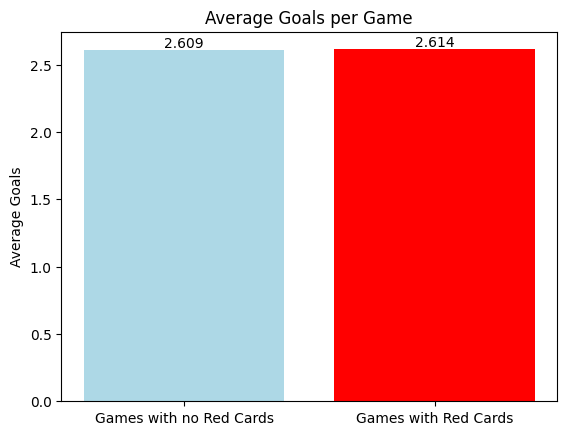

In [ ]:
# Plot bar chart
plt.bar(['Games with no Red Cards', 'Games with Red Cards'], [mean_no_red_card_goals, mean_red_card_goals], color=['lightblue', 'red'])
plt.text(0, mean_no_red_card_goals, f'{mean_no_red_card_goals:.3f}', ha='center', va='bottom')
plt.text(1, mean_red_card_goals, f'{mean_red_card_goals:.3f}', ha='center', va='bottom')
plt.ylabel('Average Goals')
plt.title('Average Goals per Game')
plt.show()

* We can observe that the difference between mean goals in games with and without red cards is very small (noticeable only at three decimal points).

In [ ]:
# Mean number of goals in matches without red card and matches with red cards
mean_specific_red_card_goals = games_df.groupby('number_of_red_cards')['number_of_goals'].mean()
mean_specific_red_card_goals

,number_of_goals
number_of_red_cards,
0,2.609072
1,2.594297
2,2.692841
3,3.021277
4,3.428571
5,3.000000


In [ ]:
# Number of games of each type
games_df.groupby('number_of_red_cards')['number_of_goals'].count()

,number_of_goals
number_of_red_cards,
0,15719
1,3086
2,433
3,47
4,7
5,2


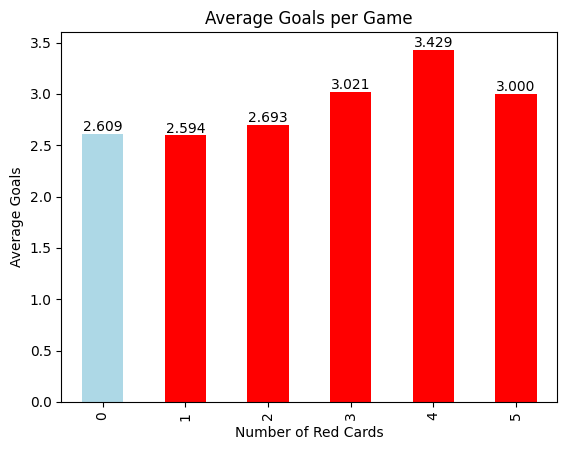

In [ ]:
# Plot bar chart of number of goals depending on number of red cards
mean_specific_red_card_goals.plot(kind='bar', color=['lightblue'] + ['red'] * (len(mean_specific_red_card_goals) - 1))
plt.xlabel('Number of Red Cards')
plt.ylabel('Average Goals')
plt.title('Average Goals per Game')
# add values to each bar
for i, v in enumerate(mean_specific_red_card_goals):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
plt.show()

We observe that an increase in the number of red cards does have an impact on the number of goals. Potentially, two or more players less on the pitch starts to have an impact, leading to more open areas, particularly when both (or more) red cards are given to the same team. It is important to mention that the number of games with 3, 4, or 5 red cards are too small to make statistical analysis.

#### Overall Correlation

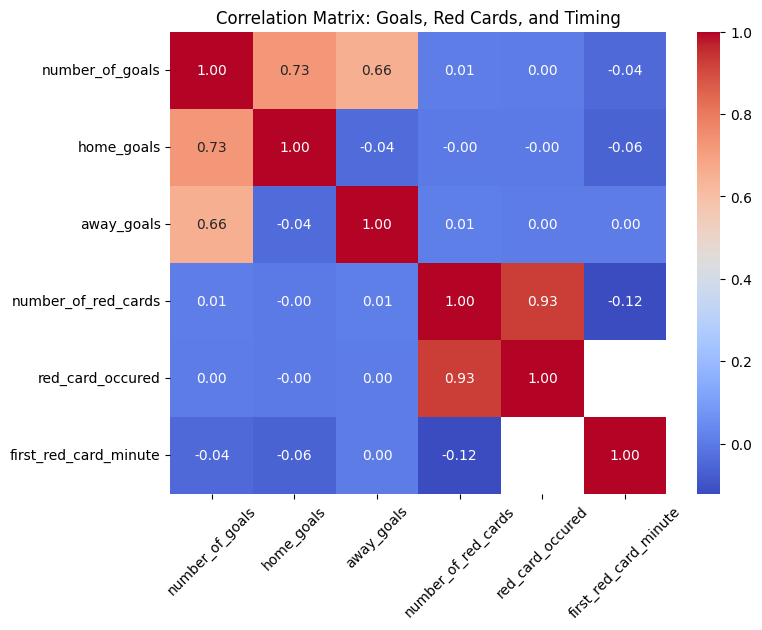

In [ ]:
# Calculate the correlation matrix
correlation_df = games_df[['number_of_goals', 'home_goals', 'away_goals', 'number_of_red_cards', 'red_card_occured', 'first_red_card_minute']]
corr_matrix = correlation_df.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix , annot=True, cmap='coolwarm', fmt='.2f')
# make the bottom text be read at an angle
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Correlation Matrix: Goals, Red Cards, and Timing')
plt.show()

We have derived features through data manipulation - number of goals, number of red cards, whether a red card occurred and the first red card minute. Here it is displayed as a correlation heatmap, with reds indicating a strong correlation and blue indicating a weaker correlation.

There does not appear to be strong correlation between our red card indicators with the number of goals. The biggest is the timing of the first red card minute, which has a negative 0.04 correlation. This suggests an earlier red card leads to a higher number of goals. However, this is still a very weak correlation, meaning it isn’t likely to have a large impact on the number of goals. As we can not see strong correlation, we’ll move on to our hypothesis modelling.

## 2. Modelling

Based on our data we will explore the following 3 questions. We will use hypothesis testing to statiscallly assess the relationship between red cards and goals. We will focus on testing built for Poisson distribution.

**Question 1:** Do games with red card events (at any point of the game) lead to an increase in the total number of goals?

* We will use a Poisson means test to compare the mean number of goals in games with and without red cards.

**Question 2:** In games where red cards occur, do earlier red card events lead to an increase in the total number of goals?

* We will use a Poisson means test to compare the mean number of goals in games where the first reds card occurs in the first half, and where the firsst red card occurs in the second half.
* We will follow this with Linear Regression model to compare the first minute a red card occurs to number of goals.

### Distribution of Our Data

To analyse our data effectively we will choose an appropriate distribution.

Firstly, we know we are working with discrete data as our dependent variable, the number of goals. So it is unlikely that our data follows a normal distribution.

Furthering that, our goals per game can't go below zero, it is unlikely that our data is symmetric, which again makes it unlikely to follow a normal distribution.

Instead, our data is more likely to follow a Poisson distribution, so let's see if it matches.

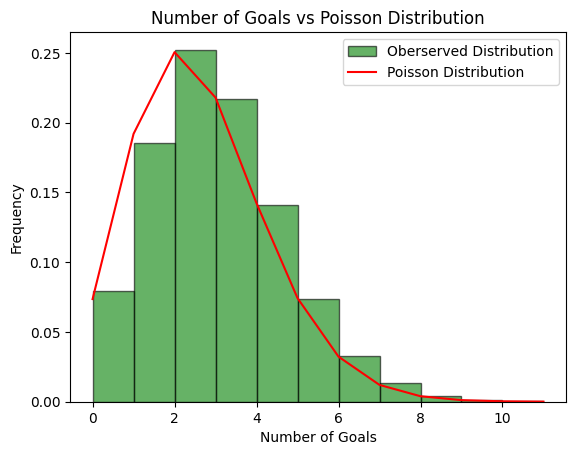

In [ ]:
from scipy.stats import poisson

# Goal totals
goal_totals = games_df['number_of_goals']

# Create a histogram of the data
plt.hist(goal_totals, bins=range(min(goal_totals), max(goal_totals) + 1), density=True, alpha=0.6, color='g', edgecolor='black', label='Oberserved Distribution')

# Generate Poisson probabilities for each number of goals
mu = goal_totals.mean()
x_values = range(min(goal_totals), max(goal_totals) + 1)
poisson_probabilities = poisson.pmf(x_values, mu)

# Plot Poisson distribution overlay
plt.plot(x_values, poisson_probabilities, 'r', label='Poisson Distribution')
plt.legend()
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Number of Goals vs Poisson Distribution')
plt.show()

We can see that Poisson Distribution (red line) appears to be a suitable fit to our data (green bars). We will assume that our data follows a Poisson distribution.

However we should note, as mentioned previously. The Poisson distribution assumes a constant rate of an event. We see from our data in our EDA, goal frequencies do tend to be higher in the second half of games, which suggests a variable rate of goals. We will choose to ignore this for this limited study.

### Question 1:  Do red cards lead to more goals overall?

#### Do games with red card events lead to an increase in the total number of goals compared to games without red cards?

**Null Hypothesis:** - Red cards *do not* lead to an increase in the total number of goals.

**Alternative Hypothesis:** - Red cards *do* lead to an increase in total number of goals.

**Significance Level/Error Rate:** - 𝛼 = 0.05 or 5%

**Model Choice:** - Poisson Mean Test.

For our hypothesis testing we will use the Poisson Means Test (or E-test). The samples are provided as the number of events k1 and k2 (number of goals) observed within measurement intervals of sizes n1 and n2 (number of games).

For our study that would be:

* k1 = total number of goals in games without red cards
* n1 = number of games without red cards
* k2 = total number of goals in games with red cards
* n2 = number of games with red cards


In [ ]:
from scipy.stats import poisson_means_test

# Split the data on red_card_occured
games_with_red_card = games_df[games_df['red_card_occured'] == 1]['number_of_goals']
games_without_red_card = games_df[games_df['red_card_occured'] == 0]['number_of_goals']

k1 = games_without_red_card.sum()
n1 = len(games_without_red_card)
k2 = games_with_red_card.sum()
n2 = len(games_with_red_card)

# Perform a poisson_means_test
test_statistic, p_value = poisson_means_test(k1, n1, k2, n2 , alternative='less')

# Display the result
print(f"Test-statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f'Average number of goals in games with red cards: {k2/n2}')
print(f'Average number of goals in games without red cards: {k1/n1}')

Test-statistic: -0.15473279207285365
P-value: 0.4380233948516299
Average number of goals in games with red cards: 2.6137062937062936
Average number of goals in games without red cards: 2.609071823907373


* The test-statistic of -0.154 indicates that the difference between the two groups (games with vs. without red cards) is very small, and this small difference is likely due to random variation rather than any true underlying effect.

* With a p-value of 0.438 or 43.8% well above the significance level of 0.05 or 5%, there is insufficient evidence to suggest that games with red cards lead to more goals than games without red cards.

We are unable to reject the null hypothesis. There is no statistically significant difference in the number of goals between games with red cards and those without.

### Question 2: Do earlier red cards lead to more goals overall?

#### In games where red cards occur, do earlier red card events lead to an increase in the total number of goals?


**Null Hypothesis:** - In games with red cards, whether  the first red card is in the first or second half does not affect the number of goals.

**Alternative Hypothesis:** - In games with red cards, when the first red card is in the first we will see an increase in the number of goals.

**Significance Level/Error Rate:** - 𝛼 = 0.05

**Model Choice:** - Poisson Mean Test.

We will again use the Poisson Means Test but this time we will look at all games with red cards and compare games where red cards occurred in the second half only to games where red cards occurred in the first half.

For our study that would be:

* k1 =  number of goals in red card games with the first red card in the second half
* n1 = number of red card games with the first red card in the second half
* k2 = number of goals in red card games with the first red card in the first half
* n2 = number of red card games with the first red card in the first half

In [ ]:
# Split data of red cards in the first or second half
games_with_red_cards_second_half = games_df[(games_df['red_card_occured'] == 1) & (games_df['first_red_card_minute'] > 45)]['number_of_goals']
games_with_red_cards_first_half = games_df[(games_df['red_card_occured'] == 1) & (games_df['first_red_card_minute'] <= 45)]['number_of_goals']

# Split the data on red_card_occured
k1 = games_with_red_cards_second_half.sum()
n1 = len(games_with_red_cards_second_half)
k2 = games_with_red_cards_first_half.sum()
n2 = len(games_with_red_cards_first_half)

# Perform a poisson_means_test
test_statistic, p_value = poisson_means_test(k1, n1, k2, n2, alternative='less')
# Display the result
print(f"Test-statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f'Average number of goals in games with red cards in the first half: {k2/n2}')
print(f'Average number of goals in games with red cards in the second half: {k1/n1}')

Test-statistic: -1.4869841236502408
P-value: 0.06708902725084635
Average number of goals in games with red cards in the first half: 2.6843291995490417
Average number of goals in games with red cards in the second half: 2.5904017857142856


* The test-statistic of -1.486 indicates the difference between the red cards occuring in the second half only and red cards occuring in the first half is small.

* Our p-value of 0.067 or 6.7% is only slightly larger than our significance level of 0.05 or 5%. So once again there is insufficient evidence to support the hypothesis but it suggests that a red card in the first half leads to a higher number of goals.

#### Linear Regression

The hypothesis compares 45 minute windows of the first and second half. We could explore at a more granular level by looking minute by minute.

Linear regression is used here because we are interested in determining the relationship between the minute the red card occurred and a dependent variable total number of goals scored. Linear regression allows us to quantify the strength and direction of this relationship.

**Independent Variable:** Minute of the first red card.

**Dependent Variable:** Total number of goals in the match.

In [ ]:
from sklearn.linear_model import LinearRegression

# Keep essential columns
lr_df = games_df[['number_of_goals', 'first_red_card_minute']]
lr_df = lr_df.dropna()

# Create X and y
X = lr_df.drop('number_of_goals', axis=1)
y = lr_df['number_of_goals']

# Fit model
lr = LinearRegression()
lr.fit(X, y)

# Check coefficients and intercepts
print("Intercept:", lr.intercept_)
print("Coefficients:",lr.coef_[0])

Intercept: 2.8093428762866597
Coefficients: -0.0030527255069675223


* The intercept represents the expected number of goals if a red card were to occur at the start of the game (minute 0). In this case, the intercept of 2.81 suggests that very early red cards (hypothetically at minute 0) are associated with a higher number of goals, slightly above the overall match mean of 2.61.

* This coefficient means that for every additional minute after the red card occurs, the total number of goals is expected to decrease by 0.0033. While this is a small effect, it implies that earlier red cards tend to result in more goals being scored, whereas later red cards are associated with slightly fewer goals.

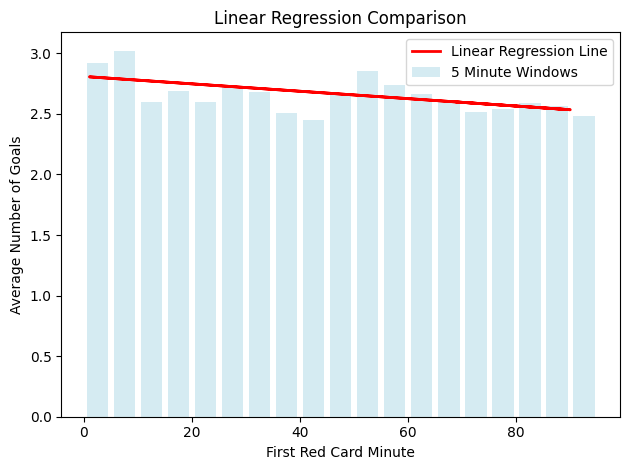

In [ ]:
# Group the data by the 'first_red_card_minute' and calculate the mean number of goals for each minute
minute_summary = games_df.groupby('first_red_card_minute')['number_of_goals'].mean()

# Split into 5 minute windows
windows_5mins = []
for i in range(0, 91, 5):
  windows_5mins.append(minute_summary.loc[i:i+5].mean())
windows_5mins

# Plot the linear regression line
plt.plot(X, lr.predict(X), color='red', linewidth=2, label='Linear Regression Line')

# Plot the summarized data for each windows_5mins
plt.bar(np.arange(2.5, 93.5, 5), windows_5mins, color='lightblue', alpha=0.5, width=4, label='5 Minute Windows')


# Add labels and legend
plt.xlabel('First Red Card Minute')
plt.ylabel('Average Number of Goals')
plt.title('Linear Regression Comparison')
plt.legend()
plt.tight_layout()
plt.show()

We see a linear regression line comparing the average number of goals at the end of the game compared with the timing a first red card has occurred.

## Further Analysis

This section provides a preliminary analysis aimed at exploring further areas. While there hasn’t been enough time for a full statistical investigation, these observations are intended to offer insights and highlight possible areas of further investigation.

**Question 3:** Does the rate of goal-scoring increase after a red card?

**Question 4:** Are more goals scored immediately after a red card event?


### Question 3: Does the rate of goal-scoring increase after a red card?

#### Is there a higher rate of goals scored when red cards have occurred compared with when red cards have not occurred?

In [ ]:
# Merge goals with red cards
q3_df = pd.merge(events_df, first_red_card_events, on='game_id', how='left')

# Filter only goals after the red card
goals_after_red_card = q3_df[(q3_df['type'] == 'goal') & (q3_df['minute'] > q3_df['first_red_card_minute'])]
goals_after_red_card = goals_after_red_card[['game_id', 'minute']]

In [ ]:
# Get total number of red cards at each interval
red_cards_per_minute = first_red_card_events.groupby('first_red_card_minute')['game_id'].nunique()

# Get the collective sum of red card games
active_red_card_games = red_cards_per_minute.cumsum()

# Get number of goals per minute
red_card_goals_per_minute = goals_after_red_card.groupby('minute')['game_id'].nunique()

# Get the average of each
mean_red_card_goals_per_minute = red_card_goals_per_minute / active_red_card_games
mean_red_card_goals_per_minute

,game_id
1,NaN
2,NaN
3,NaN
4,0.045455
5,0.066667
...,...
86,0.028247
87,0.026410
88,0.028203
89,0.035338


In [ ]:
# Grab goal_per_minute across all data
goal_minutes = events_df[events_df['type'] == 'goal']['minute'].value_counts().sort_index()
mean_goals_per_minute = goal_minutes / number_of_games

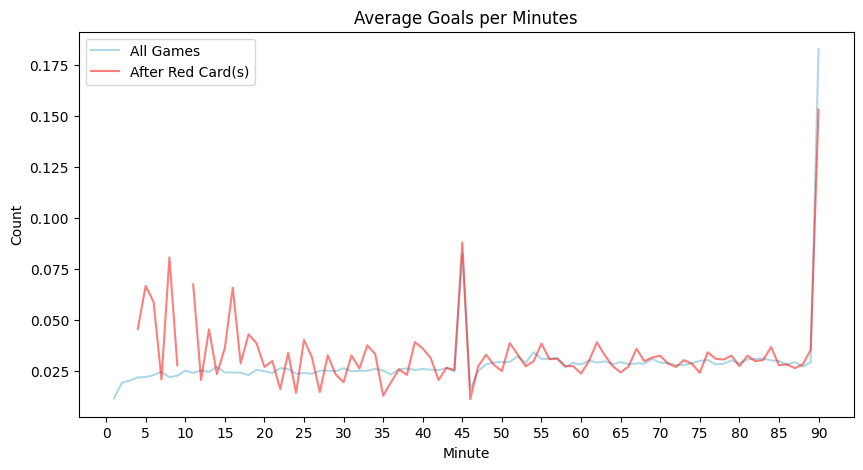

In [ ]:
# Plot goal_minutes and mean_red_card_goals_per_minute as line plot
plt.figure(figsize=(10,5))
plt.plot(mean_goals_per_minute, label='All Games', color='lightblue')
plt.plot(mean_red_card_goals_per_minute, label='After Red Card(s)', color='red', alpha=0.5)
plt.xticks(np.arange(0, 91, 5))
plt.xlabel('Minute')
plt.ylabel('Count')
plt.title('Average Goals per Minutes')
plt.legend()
plt.show()

Let's condense into 5 minute windows.

In [ ]:
# Condense mean_goals_per_minute and mean_red_card_goals_per_minute into 5 minute windows
mean_goals_per_5_minutes = []
mean_red_card_goals_per_5_minutes = []
for i in range(1, 90, 5):
  mean_goals_per_5_minutes.append(mean_goals_per_minute[i:i+5].sum())
for i in range(10, 90, 5):
  mean_red_card_goals_per_5_minutes.append(mean_red_card_goals_per_minute[i:i+5].sum())

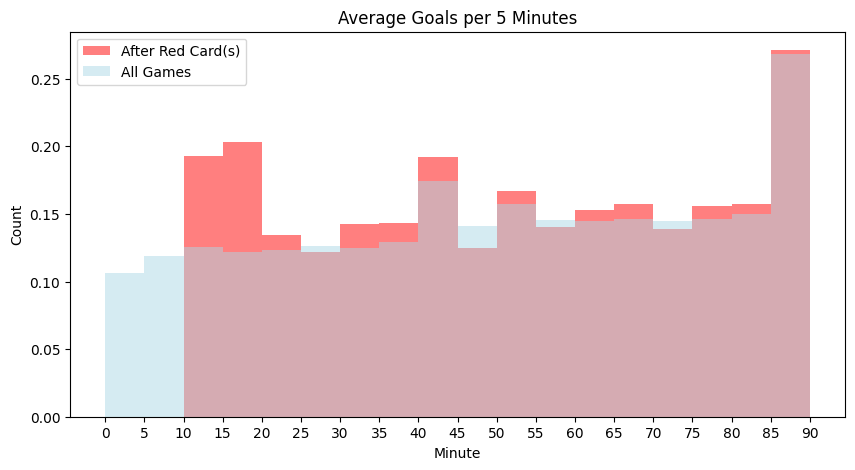

In [ ]:
# Plot 5 minute windows as bar plot
plt.figure(figsize=(10,5))
plt.bar(np.arange(12.5, 90, 5), mean_red_card_goals_per_5_minutes, width=5, label='After Red Card(s)', color='red', alpha=0.5)
plt.bar(np.arange(2.5, 90, 5), mean_goals_per_5_minutes, width=5, label='All Games', color='lightblue', alpha=0.5)
plt.xticks(np.arange(0, 91, 5))
plt.xlabel('Minute')
plt.ylabel('Count')
plt.title('Average Goals per 5 Minutes')
plt.legend()
plt.show()

We see there appears to be a slight trend to higher goal scoring rate in matches after red cards have occurred. However we could benefit from further data to even out the curves.

In [ ]:
def goals_before_and_after_red_cards(games_df, events_df, match_length):
  # Running totals
  goals_before_red_cards = 0
  goals_after_red_cards = 0
  time_before_red_cards = 0
  time_after_red_cards = 0



  # Iterate through games_df
  for index, row in games_df.iterrows():
    # If no red cards occured, add all the goals and minutes to running totals
    if row['red_card_occured'] == 0:
      goals_before_red_cards += row['number_of_goals']
      time_before_red_cards += match_length
    # If red cards did occur add minutes up to that point
    else:
      time_before_red_cards += row['first_red_card_minute']
      time_after_red_cards += match_length - row['first_red_card_minute']

  # Iterate through events_df
  for index, row in events_df.iterrows():
    # We only want goal events
    if row['type'] == 'goal':
      matching_game = games_df[games_df['game_id'] == row['game_id']]
      # We only want where red card occured because we don't have those totals yet
      if matching_game['red_card_occured'].iloc[0] == 1:
        # Goals after red cards
        if row['minute'] > matching_game['first_red_card_minute'].iloc[0]:
          goals_after_red_cards += 1
        # Goals before red cards
        elif row['minute'] < matching_game['first_red_card_minute'].iloc[0]:
          goals_before_red_cards += 1
        # We ignore any goals at the same minute


  return goals_before_red_cards, goals_after_red_cards, time_before_red_cards, time_after_red_cards

# Set our variables
g1, g2, min1, min2 = goals_before_and_after_red_cards(games_df, events_df, 90)

print(f'Goal Scoring Rate Per Minute Before Red Cards: {g1/min1}')
print(f'Goal Scoring Rate Per Minute After Red Cards: {g2/min2}')

Goal Scoring Rate Per Minute Before Red Cards: 0.02845024719904953
Goal Scoring Rate Per Minute After Red Cards: 0.03670002050883499


### Question 4: Are more goals scored immediately after a red card event?

In [ ]:
# Make a new dataframe for red cards
q4_df = events_df[events_df['type'] == 'red_card'][['game_id', 'minute']]
q4_df.columns = ['game_id', 'red_card_minute']

# Make a new dataframe for goals
q4_goals_events = goals_events[['game_id', 'minute']]
q4_goals_events.columns = ['game_id', 'goal_minute']

In [ ]:
# Merge datasets if goal_minute is after red_card_minute
q4_df = pd.merge(q4_df, q4_goals_events, on='game_id', how='left')
q4_df.fillna(0, inplace=True)
q4_df['time_difference'] = q4_df['goal_minute'] - q4_df['red_card_minute']
q4_df.head()

,game_id,red_card_minute,goal_minute,time_difference
0,1,69,23.0,-46.0
1,1,69,90.0,21.0
2,4,90,64.0,-26.0
3,4,90,32.0,-58.0
4,14,85,19.0,-66.0


In [ ]:
# Calculate number of goals from red card
time_after_red_card = {}
for i in range(1,11):
  goal_group = q4_df[q4_df['time_difference'] == i]
  time_after_red_card[i] = len(goal_group)

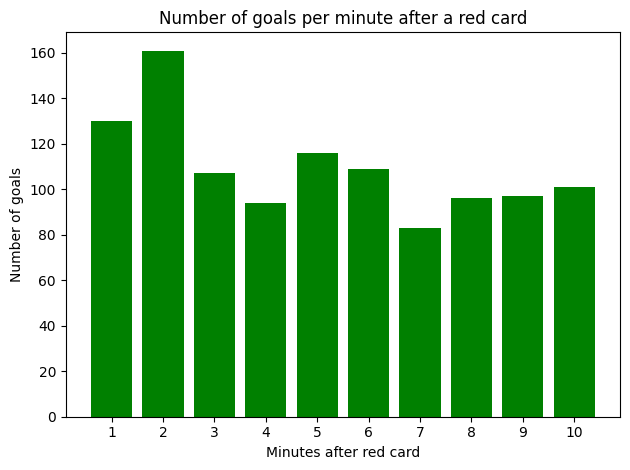

In [ ]:
# Plot bar chart
keys = list(time_after_red_card.keys())
values = list(time_after_red_card.values())
max_index = values.index(max(values))
plt.bar(keys, values, color='green')
plt.xticks(keys)
plt.xlabel('Minutes after red card')
plt.ylabel('Number of goals')
plt.title('Number of goals per minute after a red card')
plt.tight_layout()
plt.show()

The chart shows the number of goals scored per minute following a red card event. Each bar represents the number of goals scored in the respective minute after a red card is shown.

In [ ]:
# Make in df
time_after_red_card_df = pd.DataFrame(list(time_after_red_card.items()), columns=['minutes_after_red_card', 'number_of_goals'])
time_after_red_card_df.T

,0,1,2,3,4,5,6,7,8,9
minutes_after_red_card,1,2,3,4,5,6,7,8,9,10
number_of_goals,130,161,107,94,116,109,83,96,97,101


There is an initial spike in goal-scoring immediately after a red card, especially in the first and second minutes, where the number of goals, 130, and 161, is significantly higher than in later minutes.

This observation points to a strong immediate impact of red cards on goal-scoring. Potential theories could be either the tactical or emotional of the red card events that were stabilised shortly afterwards.

However the data we have is a small sample and requires further statistical analysis to confirm whether this pattern holds across a broader set of matches.


## 4. Conclusions

The analysis conducted on the relationship between red cards and goals in football matches suggests several key insights:

* **Overall Impact of Red Cards:**

Our first hypothesis, Question 1, that red cards lead to more goals overall was tested using a Poisson Means Test or E-test. The results showed no statistically significant difference between the average number of goals scored in games with red cards and those without. This suggests that red cards, in general, do not have a statistically significant impact on the overall number of goals in a match (assuming that the limitations of using the Poisson distribution noted earlier are not affecting the overall results). However, the difference in the mean numbers between when a red card event did or not occur suggests that there is a small impact.

* **Timing of Red Cards:**

Our comparison of a first red card occurring in the first or second half did not provide us enough evidence to support our hypothesis for Question 2. However, it did result in a fairly low p-value, 6.7%, close to significance, and it supported a trend which we were able to see with our investigation through a Linear Regression model. Further analysis of the linear trend revealed that the timing of the first red card event does play a role. Earlier red cards tend to result in more goals. For each additional minute before the red card occurs, the total number of expected goals decreases slightly.

* **Goal-Scoring Rate per Minute:**

The analysis of goal-scoring rates after a red card event showed evidence of a higher rate of goals in comparison to before red cards (or none at all). The goal-scoring rate per minute before red cards is 0.028, in comparison to after red cards, which is 0.037. Across 90 minutes, this reflects 2.52 goals per game before red cards, and 3.33 goals per game after red cards. There may be other factors that correlate, such as minutes after red cards more often being in the second half where there are typically more goals, but these are unlikely to have a large impact on our results. For further insights, we could source more accurate records of goal and red card event timings during added time, this would impact our overall expected goals.
